# Network Embedding via Random Walks - from previous results

## Import modules and Data

In [1]:
import pandas as pd
import numpy as np
import random
import networkx as nx
from matplotlib import pyplot as plt 
np.random.seed(15)

In [2]:
#Load data
adjlist = nx.read_adjlist("karate_club.adjlist", nodetype=int)
#karate_label = np.loadtxt("karate_label.txt")
karate_label = np.loadtxt("karate_label.txt")
Graph = nx.read_adjlist("karate_club.adjlist", nodetype=int)
node_number = nx.to_pandas_adjacency(Graph).columns

In [3]:
adj = nx.to_numpy_array(adjlist)
#label = karate_label[:,-1]

print(adj.shape)
#print(label.shape)

(34, 34)


## Nerual Network class
+ used softmax function instead of sigmoid when feed_forward
+ unlike 2-nn we made, deleted activation after hidden layer (after passing W1) sin ce its from word2back network 

+ backpropagation process is simliar to ass 2

In [4]:
#actiavtion function 
def softmax(x):
    c = np.max(x)
    b = x-c
    exp_x = np.exp(b)
    sum_exp_x = np.sum(exp_x)
    y = exp_x / sum_exp_x
    return y

In [5]:
#fully conneted network
class ann:
    def __init__(self, input_size, hidden_size,output_size):
        #setting the shape of the layer and putting random inital value 
        self.params = {}
        self.params['W1'] = np.random.randn(input_size,hidden_size)
        self.params['W2'] = np.random.randn(hidden_size,output_size)
    
    #Calculating the Values
    def gradient(self, x, y):
        
        #forward
        W1,W2 = self.params['W1'],self.params['W2']
        h = np.dot(x,W1)
        #H = softmax(U)
        
        U2 = np.dot(h,W2)
        Y = softmax(U2)
        
        diff = (Y-y) # 34*1
        
        ERR2 = np.outer(h,diff)

          
        #backpropagation
        #ERR2 = (-np.log(np.abs(Y-y)))*Y*(1-Y)
        ERR = np.outer(x,np.dot(W2,diff))
        
        
        
        
        
        return ERR,ERR2,diff,Y
        

## initializing variable and params

In [6]:
w = 3 #window_size w
d = 4 #embedding size d
r = 10 # walks per vertex
t = 10 # walk length
learning_rate = 0.0001

In [7]:
#Params
n_network = ann(input_size = 34,hidden_size = d,output_size = 34)
#P = np.random.random((34,d)) # Work as W1 (input_size,hidden_size)
#Q = np.random.random((d,34)) # work as W2 (hidden_size, input_size)

## Main Function
+ random_walk ( find near vertexs and choose )
+ skipgram (make windows depending on window size)
+ updated params in skipgram

In [8]:
def random_walk(vertex,t):
    ans = []
    ans.append(vertex)
    
    while True:
        #stop untill the window size get t
        if len(ans) == t:
            return ans
            
        #check nearest vertexs
        vertex_adj_list = list(adj[vertex]) 
        near_vertex_index = np.nonzero(vertex_adj_list)
    
        #choose the nearess vertex randomly
        get_vertex = np.random.choice(list(near_vertex_index[0]),1)
        ans.append(get_vertex[0])
        vertex = get_vertex[0]


In [9]:
def skipgram(W,w,loss):
    new_loss = np.zeros(34)
    loss = 0
    for idx, vertex in enumerate(W):
        #making u_list considering w
        start = idx-w
        end = idx+w
        if start < 0:
            start = 0
        if end >= len(W):
            end = len(W)-1

        u_list = []
        u_list.extend(W[start:idx])
        u_list.extend(W[idx+1:end+1])
        
        #calculating each u from u_list
        for each_u in u_list:
            
            # input, ouput with one-hot encoding
            input_vertex = np.zeros(34)
            y_pred = np.zeros(34)
            v = vertex
            u = each_u
            input_vertex[v] = 1
            y_pred[u] = 1
            
            #gradient (forward,backpropa)
            
            ERR,ERR2,diff,Y = n_network.gradient(input_vertex,y_pred)
            #updata params
            n_network.params['W1'] -= learning_rate * ERR
            n_network.params['W2'] -= learning_rate * ERR2
            #n_network.params['W2'] -= np.reshape(learning_rate * ERR2 * H.T, (d,34))
            
    
            #calculating loss
            loss += -np.log(Y[each_u])
        #new_loss = new_loss / len(u_list)
    return loss

In [10]:
epoch = 200
epoch_loss2 = []
loss = np.zeros((34,34))
for _ in range(epoch):
    epoch_loss = 0

    for i in range(r):
        O = np.arange(34) 
        np.random.shuffle(O)
    
        for vertex in O:
            W = random_walk(vertex,t)
            loss = skipgram(W,w,loss)
            epoch_loss += (loss /len(W))
                
    #h = np.dot(adj[1],W1)
    #H = softmax(U)
        
    #U2 = np.dot(h,W2)
    #Y = softmax(U2)      
    #aa = np.mean(-np.log(Y -adj[1]))
    epoch_loss2.append(np.mean(epoch_loss)/(len(O)*r))
    #calculating loss
    #n_networ.params['W1']    

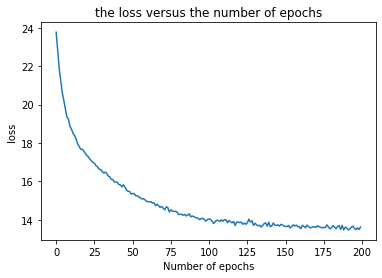

In [11]:
from matplotlib import pyplot as plt
plt.plot(epoch_loss2)
plt.title("the loss versus the number of epochs")
plt.xlabel("Number of epochs")
plt.ylabel("loss")
plt.show()

## Plotting in 2-dim with TSNE

+ it seems that nearest vertexs have "1"s in adj matrix
+ but there are many wrong ones (which means some are faraway eventhough they have"1"
+ it will probably improved when hidden layer (which is d) get higher
+ Erased labels since didnt need at all

In [12]:
nums = np.identity(34)
W1 = n_network.params['W1']
output = np.dot(nums , W1)
adj = nx.to_numpy_array(adjlist)
label = karate_label[:,-1]

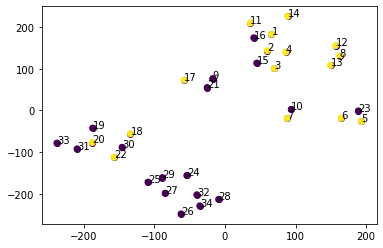

In [13]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

model = TSNE(learning_rate=100,perplexity=5)
transformed = model.fit_transform(output)
xs = transformed[:,0]
ys = transformed[:,1]

for i in range(len(xs)):
    plt.scatter(xs[i],ys[i],c = node_number[i])
    plt.text(xs[i],ys[i],i+1)
plt.scatter(xs,ys,c=label)
#plt.text(xs,ys)

plt.show()


## Logistic Regression

In [14]:
# define data_x, label y
x_data = output
t_data = np.array(label).reshape(34,1)
print(x_data.shape)
print(t_data.shape)

(34, 4)
(34, 1)


In [15]:
def sigmoid(x):
    return 1/(1+np.exp(-x))
    
def loss_func(x, t):
    delta = 1e-7
    z=np.dot(x,w)+b
    y=sigmoid(z)
    return -np.sum(t*np.log(y+delta)+(1-t)*np.log((1-y)+delta))

In [16]:
def numerical_derivative(f, x):
    delta_x = 1e-4 
    grad = np.zeros_like(x) # cal grads
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    
    while not it.finished:
        idx=it.multi_index
        
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + delta_x
        fx1 = f(x)
        
        x[idx] = tmp_val - delta_x
        fx2 = f(x)
        
        grad[idx] = (fx1 - fx2) / (2*delta_x)
        
        x[idx] = tmp_val
        it.iternext()
        
    return grad

def predict(x):
    z = np.dot(x,w) + b
    y = sigmoid(z)
    
    if y > 0.5: #0.5를 초과하면 1로 True, 이하면 0으로 False
        result = 1
    else:
        result = 0
        
    return result

In [17]:
#Param Setting
learning_rate = 1e-2
f = lambda x : loss_func(x_data, t_data)


In [19]:
np.random.seed(2)
#Param Setting
learning_rate = 1e-2
# GET 10 time results
right_10 = []
accuracy_10 = []
precision_10 = []
recall_10 = []
f1_10 = []

# define data_x, label y
x_data = output
t_data = np.array(label).reshape(34,1)
total = np.concatenate([x_data,t_data],axis = 1)

#Portion setting
portion_set = [0.05,0.15,0.25,0.35,0.45,0.55,0.65]
portion_f1 = []
for pro in portion_set:
    for _ in range(10):
    
        #Shuffle Data
        np.random.shuffle(total)
        x_data = total[:,:-1]
        t_data = total[:,-1]
        t_data = np.array(t_data).reshape(34,1)
    
        #Data Split
        portion = pro
        tem = int(34 * portion)
        x_test = x_data[34-tem:]
        t_test = t_data[34-tem:]

        x_data = x_data[:34-tem]
        t_data = t_data[:34-tem]
    
        #initalizing
        w = np.random.rand(4,1)
        b = np.random.rand(1)
    
    
        loss = []
        for step in range(10000):
            w -= learning_rate *numerical_derivative(f,w)
            b -= learning_rate *numerical_derivative(f,b)
            if(step%10==0):
                l = loss_func(x_data, t_data)
                loss.append(l)
    
        #make prediction
        pred = []
        for i in range(len(x_test)):
            tem = predict(x_test[i])
            pred.append(tem) 
        
        
        #prediction
        y = t_test
        y= y.flatten()
        p = np.array(pred) 


        accuracy = np.mean(np.equal(y,p))
        right = np.sum(y * p == 1)
        precision = right / np.sum(p)
        recall = right / np.sum(y)
        f1 = 2 * precision*recall/(precision+recall)

        accuracy_10.append(accuracy)
        right_10.append(right)
        precision_10.append(precision)
        recall_10.append(recall)
        f1_10.append(f1)
        
    portion_f1.append(np.mean(np.array(f1)))
    
print('accuracy',np.mean(np.array(accuracy)))
print('precision', np.mean(np.array(precision)))
print('recall', np.mean(np.array(recall)))
print('f1', np.mean(np.array(f1)))

<ipython-input-19-2e173eec26d5>:66: RuntimeWarning: invalid value encountered in true_divide
  recall = right / np.sum(y)
<ipython-input-19-2e173eec26d5>:65: RuntimeWarning: invalid value encountered in long_scalars
  precision = right / np.sum(p)
<ipython-input-19-2e173eec26d5>:67: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * precision*recall/(precision+recall)


accuracy 0.8181818181818182
precision 0.8
recall 0.8
f1 0.8000000000000002


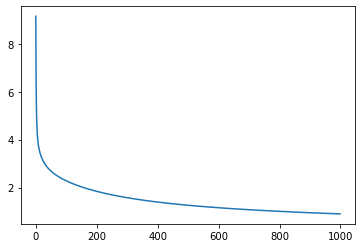

In [20]:
#sample loss
plt.plot(loss)

# Results
+ like matrix factorization, loss decreased well
+ f1 score seems to have high scores when separted well
+ but since i separated randomly, it didnt show consistency

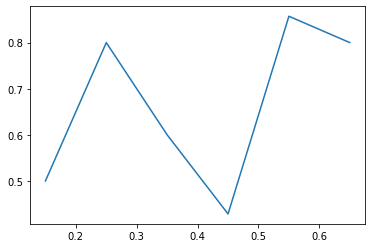

In [21]:
#Plotting f1 score with different portion
plt.plot(portion_set, portion_f1)